# Projeto 1: Regressão Linear

O projeto consiste em explorar modelos de regressão linear para prever o volume de tráfego de uma rodovia [Interstate 94](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) a partir de 8 _features_ :

- Feriado
- Temperatura (em Kelvin)
- Chuva (em 1h)
- Neve (em 1h)
- Nuvens (porcentagem)
- Clima (curto)
- Clima (longo)
- Data/Hora

O valor alvo é o volume de tráfego, que também está disponível no _dataset_.

In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import date as date_check 
from holidays import UnitedStates
from random import randint, sample
from sklearn import linear_model

Primeiro, podemos __visualizar__ os dados por meio da biblioteca de visualização abaixo:

In [2]:
def stats_hist(data):
    ''' Transforms data to pandas dataframe and gets stats/histogram
    '''
    pd.DataFrame(data)
    print(data.describe())
    hist=data.hist(bins=50)
    plt.show()

def date_split(string):
    ''' Read date-time in "yyyy-mm-dd hh:mm:ss" and cast to int.

        Parameters:
            string (string): string containing the mentioned format.

        Returns:
            (dictionary): contains date-time info indexed by initials.
    '''
    date = re.split("-|:| ", string)
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    hour = int(date[3])

    return {"h":hour, "d":day, "m":month, "y":year}

# Plots a relation between the average daily traffic per hour
def avg_traffic_hour_daily(data):
    # OBS: there are duplicated time stamps to separate more than one
    # enviromental condition (p.e. if its foggy and cloudy there will be duplicates)
    curr_day = 0
    traffic_hour = []
    for x in data[1:] :
        hour, day, _, _ = date_split(x[7]).values()
        if (day != curr_day):
            curr_day = day
            traffic_hour.append(np.array([0]*24))
        traffic_hour[-1][hour] = x[-1]

    avg = sum(traffic_hour)/len(traffic_hour)
    plt.plot(range(0,24), avg)
    plt.xticks(range(0,24))
    plt.title("Análise do tráfego por hora")
    plt.xlabel("Horas do dia (00h-24h)")
    plt.ylabel("Média diária de tráfego")
    print('Plotting')
    plt.grid()
    plt.show()

    return

def avg_traffic_day_weekly(data):
    # NEEDS HEADER
    # OBS: there are duplicated time stamps to separate more than one
    # enviromental condition (p.e. if its foggy and cloudy there will be duplicates)
    traffic_day = []
    data = pd.DataFrame(data)
    data['date_time'] = pd.to_datetime(data['date_time'])
    data['weekday'] = data['date_time'].dt.weekday
    
    for i in range(0,7):
        dt = data.loc[data['date_time'].dt.weekday == i]
        traffic_day.append(dt['traffic_volume'].mean())
        
    plt.plot(range(0,7), traffic_day)
    plt.xticks(range(0,7))
    plt.title("Análise do tráfego por dia")
    plt.xlabel("Dias da semana (Segunda a Domingo)")
    plt.ylabel("Média semanal de tráfego")
    print('Plotting')
    plt.grid()
    plt.show()

    return

# Plot a realtion between weather descriptions and the average daily traffic per hour
def avg_traffic_per_weather(data):

    desc_main = {y:[0,0] for y in list(set([x[5] for x in data[1:]]))}
    desc = {y:[0,0] for y in list(set([x[6] for x in data[1:]]))}
    
    for x in data[1:]:
        desc_main[x[5]][0] += 1
        desc_main[x[5]][1] += int(x[-1])
        desc[x[6]][0] += 1
        desc[x[6]][1] += int(x[-1])

    counts = [x[0] if x[0]>0 else 1 for x in desc_main.values()]
    sums = [x[1] for x in desc_main.values()]
    desc_main_avg = np.array(sums)/np.array(counts)

    counts = [x[0] if x[0]>0 else 1  for x in desc.values()]
    sums = [x[1] for x in desc.values()]
    desc_avg = np.array(sums)/np.array(counts)
    
    a = plt.figure(1)
    plt.plot(list(desc.keys()), desc_avg)
    plt.xticks(list(desc.keys()), rotation='vertical')
    plt.margins(0)
    plt.subplots_adjust(bottom=0.5)
    plt.title("Análise do tráfego por descrição específica do clima")
    plt.xlabel("Descrições específicas do clima")
    plt.ylabel("Média diária de tráfego")
    plt.grid()
    
    b = plt.figure(2)
    plt.plot(list(desc_main.keys()), desc_main_avg)
    plt.title("Análise do tráfego por descrição geral do clima")
    plt.xlabel("Descrições gerais do clima")
    plt.ylabel("Média diária de tráfego")
    
    plt.grid()
    plt.show()
    input()
    
    return


Plotting


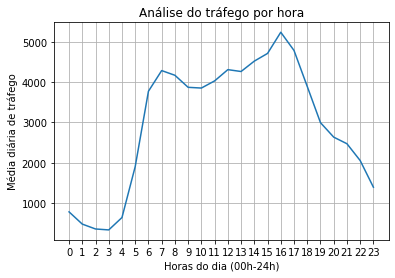

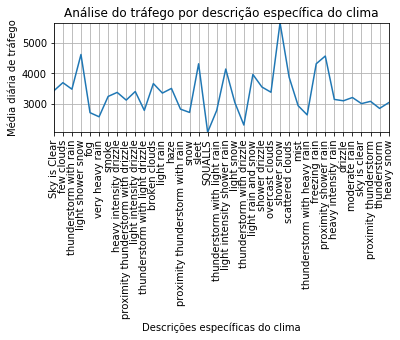

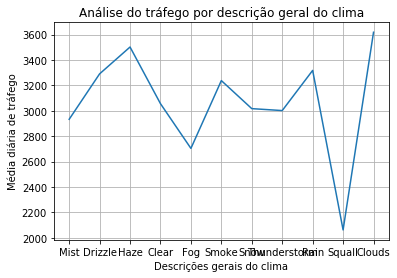

In [ ]:
dataset = open('Datasets/dataset_with_column_names.csv')
data = list(map(lambda x: x.split(","), dataset.readlines()))
avg_traffic_hour_daily(data)
avg_traffic_per_weather(data)
dataset.close()

data=pd.read_csv('Datasets/dataset_with_column_names.csv')
avg_traffic_day_weekly(data)


Pode-se notar relações entre algumas _features_ e o valor objetivo. As relações mais clara e fáceis de explicar são entre horários de pico durante o dia e maior tráfego durante a semana. 

Feito isso, temos que realizar uma __engenharia de features__ , que consiste em criar _features_ novas a partir das que temos, e deixá-las em um estado útil (numérico). Dois conjuntos de _features_ foram feitos.

O primeiro conjunto verifica os feriados pela biblioteca "holidays", e expande via One Hot Encoding quase tudo: descrição detalhada (certos tipos) e resumida de clima, dias da semana, horas do dia. Ambos conjuntos eliminam valores com medições de temperatura em zero absoluto, valores absurdos de chuva e valores duplicados, considerando apenas o primeiro.

In [ ]:
def process_input_first(data):
    ''' Remove and re-format input data.

        Parameters:
            data (array list): csv table with the dataset header and content.
            
        Returns:
            data_frame (array list):  processed input data.
    '''

    # Features list
    new_head = ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'thunderstorm with light rain', 'shower snow', 'thunderstorm with heavy rain', 'drizzle', 'light intensity shower rain', 'proximity shower rain', 'thunderstorm', 'heavy snow', 'proximity thunderstorm with rain', 'thunderstorm with rain', 'proximity thunderstorm', 'squalls', 'few clouds', 'light rain and snow', 'smoke', 'scattered clouds', 'thunderstorm with light drizzle', 'sky is clear', 'very heavy rain', 'light intensity drizzle', 'broken clouds', 'snow', 'heavy intensity rain', 'sleet', 'thunderstorm with drizzle', 'heavy intensity drizzle', 'light snow', 'light shower snow', 'moderate rain', 'haze', 'shower drizzle', 'proximity thunderstorm with drizzle', 'fog', 'mist', 'overcast clouds', 'freezing rain', 'light rain', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 'mon', 'tue', 'wed', 'thu', 'fry', 'sat', 'sun', 'traffic_volume']
    data_frame = [new_head]
    holidays = UnitedStates(state='MN')

    # Alter and remove data
    for (i,d) in enumerate(data[1:], start=1):
        # Cast weather description to lower case
        data[i][6] = d[6].lower()

        # Propagate holidays and cast them to binary
        if d[0] == 'None' : 
            # In case theres no holiday
            data[i][0] = 0.0 
        elif d[-2].split()[0] in holidays:
            # In case its a known minnesota holyday date
            data[i][0] = 1.0 
        else:
            # Unknown holidays are discarded for simplicity
            data[i][0] = 0.0

    # # Discrete variables lists
    weekdays = {0:"mon", 1:"tue", 2:"wed", 3:"thu", 4:"fry", 5:"sat", 6:"sun"}
    # desc_list = list(set([x[6] for x in data[1:]])) # Get unique values
    # hour_list = list(map(str,range(0,24)))
    
    # # Defining the new header and frame for processed data
    # new_head = data[0][0:5] + desc_list + hour_list + list(weekdays.values()) + [data[0][-1][0:-1]]

    # Indexes to be casted
    cast_float = [1,2,3,4,8]

    for i in range(1,len(data)):
        # Ignore data with 0 kelvin
        if float(data[i][1]) == 0 : continue
        # Ignore duplicate hours (due to multiple weather description)
        if data[i-1][-2] == data[i][-2] : continue
        # Ignore ridiculous ammounts of rain
        if float(data[i][2]) > 300 : continue
        # Cast numeric values read as string to float
        for j in cast_float : 
            data[i][j] = float(data[i][j]) 

        # Add row to dataframe
        data_frame.append([0.0]*len(new_head)) 
        
        # split and cast date
        hour, day, month, year = date_split(data[i][-2]).values()

        # Set discrete weekday variable
        day_name = weekdays[date_check(year,month,day).weekday()]
        data_frame[-1][new_head.index(day_name)] = 1.0

        # Set discrete hour variable
        data_frame[-1][new_head.index(str(hour))] = 1.0

        # Set discrete weather description variables
        j = i
        while j < len(data) and data[j][-2] == data[i][-2] :
            data_frame[-1][new_head.index(data[j][6])] = 1.0 
            j += 1

        # Set quantitative data
        data_frame[-1][-1] = data[i][-1]
        data_frame[-1][:5] = data[i][:5]     

    return data_frame

def prepare_dataset_first(set_name):
    ''' Reads and prepares a dataset for regression.
    
        Returns:
            X (array list): coeficients matrix with label.
            Y (array list): results matrix with label.
    '''

    datafile = open(set_name)
    data = list(map(lambda x : x.split(","), datafile.readlines()))

    data = process_input(data)
    
    # Separate processed data in coeficients and results
    X = data[1:] # Remove header
    Y = [[x.pop()] for x in X]

    # Returns processed input and indexes to be normalized
    return X, Y, [1,2,3,4]

O segundo conjunto de _features_ foi feito com a intenção de reduzir a redundância, diminuindo o tamanho da matriz final. Para isso foram cogitadas diversas _features_ novas baseadas na visualização dos dados feita acima.
Dias da semana agora foram divididos entre "weekday" ou não, e as informações da hora, do dia, mês e ano de cada exemplo também foram incluídas. Porém, foram eliminadas as _features_ que indicam feriados e cada dia da semana separadamente.
Foram cogitadas _features_ representando horários de pico, comercial e noturno, porém foi verificado que tornavam o modelo pior que apenas enumerar as horas.
Nesse modelo, apenas as descrições resumidas do clima foram utilizadas, pois as descrições detalhadas eram muito específicas de poucos dias.

Com as _features_ do conjunto, uma parte importante do processo é a normalização dos dados, podendo ser feita como:

- _Min-Max Normalization_ : 
- _Standardization_ :
- _Mean Normalization_ :

O conjunto de _features_ inclui também uma lista de quais deverão sofrer normalização.

In [ ]:
def normalize_data(data, choice=1, features=[1,2,3,4]):
    ''' Returns the normalized dataset.
    
        Parameters:
            data (array list): csv table with the dataset (without the header).
            choice (int): integer indicating the transformation to be used.
            features (int list): Indexes of the features to be normalized.

        Returns:
            data (array list):  transformed data (original data is lost).
    '''

    # Data to be colected
    ranges = []
    means = []
    maxs = []
    mins = []
    stds = []

    # Gathering necessary data
    features_list = [[d[f] for d in data] for f in features]
    for fl in features_list:
        means.append(np.mean(fl))
        maxs.append(max(fl))
        mins.append(min(fl))
        stds.append(np.std(fl))
        ranges.append(maxs[-1]-mins[-1])

    #### Transforming the dataset ####

    if choice == 1:
        # Min-max normalization
        for entry in data:
            for (i,f) in enumerate(features):
                entry[f] = (entry[f] - mins[i])/ranges[i]  
    elif choice == 2:
        # Standardization
        for entry in data:
            for (i,f) in enumerate(features):
                entry[f] = (entry[f] - means[i])/stds[i]
    elif choice == 3:
        # Mean normalization
        for entry in data:
            for (i,f) in enumerate(features):
                entry[f] = (entry[f] - means[i])/ranges[i] 
                
    return data

A partir deste ponto, X se refere à matriz de _features_ , e Y se refere aos valores alvo. Será utilizado _Min-Max Normalization_ .

In [ ]:
# ### Getting Training Set ###
# Returns the data split between features and target.
X_1, Y_1, feat_list_1 = prepare_dataset_first("Datasets/training.csv")
X_2, Y_2, feat_list_2 = prepare_dataset_last("Datasets/training.csv")

# Normalize the features pointed by the received model
X_1 = normalize_data(X_1, choice=1, features=feat_list_1)
X_2 = normalize_data(X_2, choice=1, features=feat_list_2)

# Validation set
# features to be normalized are the same
X_val_1, Y_val_1, _ = prepare_dataset_first("Datasets/validate.csv")
X_val_2, Y_val_2, _ = prepare_dataset_last("Datasets/validate.csv")
X_val_1 = normalize_data(X_val_1, choice=1, features=feat_list_1)
X_val_2 = normalize_data(X_val_2, choice=1, features=feat_list_2)
